In [1]:
%matplotlib notebook
## Imports
## System packages
import os, glob, pdb

## Data formatting and structure packages
import numpy as np
import h5py
import pandas as pd
import xarray as xr

import h5py

## Geospatial packages
import geopandas as gpd
from pyproj import Proj, Transformer, CRS

## Plotting packages
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show

import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### First, we enable phoreal functions to be read.

In [2]:
import sys

sys.path.insert(1,'/home/s1803229/src/PhoREAL') #for linux
# sys.path.insert(1,'C:/Users/s1803229/Documents/PhoREAL-master') #for windows

In [3]:
from phoreal.reader import get_atl03_struct#, get_file_name, \
#                             read_atl03_heights_data, get_atl03_classification, \
#                             get_atl03_heights_offset, get_atl03_segment_id, get_atl03_rate, \
#                             get_atl03_dist_ph_along, get_atl_time, get_atl_coords, get_atl_alongtrack, \
#                             get_direction

#### We set the paths for atl03 and atl08 files, in this case for Arthu's Seat in August 2021.

In [4]:
atl03path = "../data/august_2021_arthurs_seat_preprocessed/processed_ATL03_20210804143024_06411202_006_01.h5"
atl08path = "../data/august_2021_arthurs_seat_preprocessed/processed_ATL08_20210804143024_06411202_006_01.h5"

In [5]:
# A = h5py.File(atl03path, 'r')
# A['gt3l'].keys()

#### We create an atl03struct using the phoreal function.

In [28]:
atl03 = get_atl03_struct(atl03path, 'gt1r', atl08path)

#### Take a look at the info to consider what we want to plot

In [29]:
atl03.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7168 entries, 0 to 7167
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   delta_time      7168 non-null   float64
 1   dist_ph_across  7168 non-null   float32
 2   dist_ph_along   7168 non-null   float64
 3   h_ph            7168 non-null   float32
 4   lat_ph          7168 non-null   float64
 5   lon_ph          7168 non-null   float64
 6   pce_mframe_cnt  7168 non-null   uint32 
 7   ph_id_channel   7168 non-null   uint8  
 8   ph_id_count     7168 non-null   uint8  
 9   ph_id_pulse     7168 non-null   uint8  
 10  quality_ph      7168 non-null   int8   
 11  signal_conf_ph  7168 non-null   int8   
 12  weight_ph       7168 non-null   uint8  
 13  classification  7168 non-null   int64  
 14  norm_h          7166 non-null   float64
 15  seg_id          7168 non-null   int32  
 16  ph_bihr         7168 non-null   float64
 17  ph_bcr          7168 non-null   f

#### In the following two plots, we can see the gt1r (strong beam) data crossing Holyrood Park on August 24th, 2021 in the early afternoon. We have the unclassified ATL03 data in the first plot, and we have a visualisation of the track crossing Whinnie Hill in the second plot.

<IPython.core.display.Javascript object>


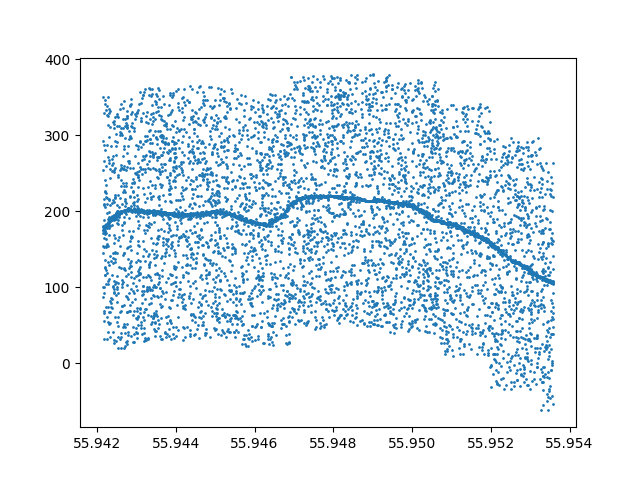

In [30]:
fig, ax = plt.subplots(1,1)
ax.scatter(atl03.df['lat_ph'], atl03.df['h_ph'], s=1)

<IPython.core.display.Javascript object>


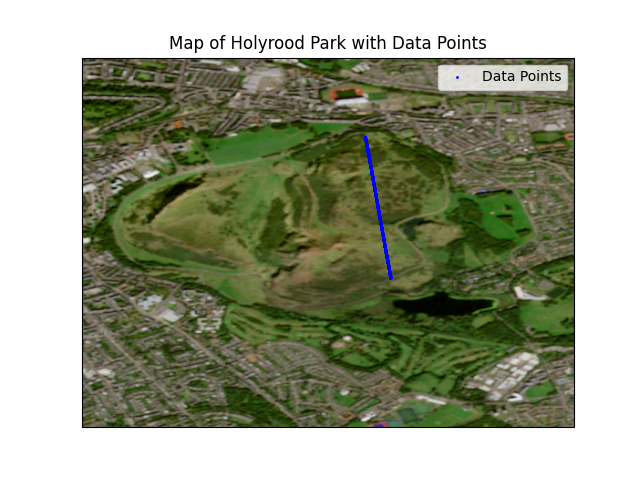

In [31]:
# Sample DataFrame with latitude and longitude columns
# Replace this with your actual DataFrame
df = atl03.df.loc[:,['lat_ph','lon_ph']]

# Create a map with Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-3.18, -3.14, 55.93, 55.96])  # Set the map extent to cover Edinburgh

# Plot points from the DataFrame
ax.scatter(df['lon_ph'], df['lat_ph'], color='b', marker='o', label='Data Points', zorder=3, s=1)

tif = rasterio.open('../data/arthurs_seat_image/2023-09-04-00_00_2023-09-04-23_59_Sentinel-2_L2A_True_color.tiff')
show(tif, ax=ax, transform=ccrs.PlateCarree())

# Add labels, title, and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Map of Holyrood Park with Data Points')
ax.legend()

# Show the plot
plt.show()

#### Let's try to plot the data again, but with the ATL08 classifications. I'm going to steal some of the useful functions from Matt's practical.

In [32]:
from matplotlib.cm import gist_earth as cmap

class_dict = {-1: {'color':cmap(1.0),
                   'name':'Unclassified'},
               0: {'color':cmap(0.2),
                   'name':'Noise'},
               1: {'color':cmap(0.8),
                   'name':'Ground'},
               2: {'color':cmap(0.4),
                   'name':'Canopy'},
               3: {'color':cmap(0.6),
                   'name':'Top of canopy'}}

def plot(df, ax):
    for c in np.unique(df.classification):
        mask = df.classification==c
        ax.scatter(df[mask].lat_ph,
                   df[mask].h_ph,
                   color=class_dict[c]['color'],
                   label=class_dict[c]['name'],
                   s = 5)
    ax.set_xlabel('Latitude (°)')
    ax.set_ylabel('Elevation (m)')
    ax.legend(loc='best')

<IPython.core.display.Javascript object>


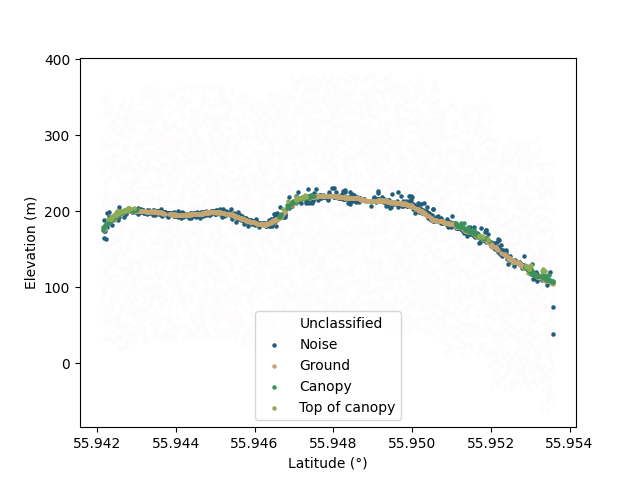

In [33]:
fig,ax = plt.subplots(1,1)
plot(atl03.df, ax)

#### Nice one, the next step is to compute $\rho_v/\rho_g$.

<IPython.core.display.Javascript object>


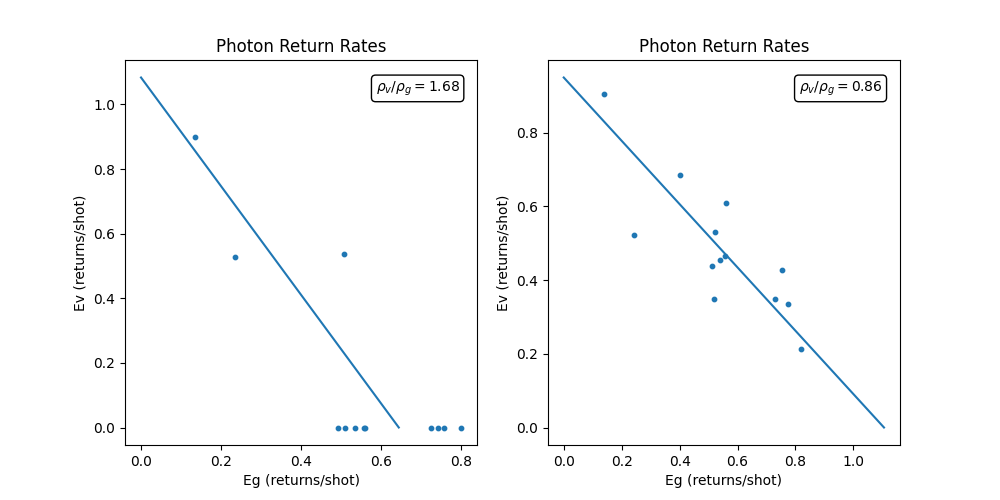

In [46]:
from scipy.odr import Model, Data, ODR

def linear_model(params, x):
    return params[0]*x + params[1]

linear = Model(linear_model)

Eg = []
Ev = []

i = 0
Ng = 0
Nv = 0
Npulses = 0

for segment in atl03.df['seg_id'].unique():
    
    A = np.array(atl03.df[atl03.df['seg_id'] == segment]['ph_id_pulse'].unique(),dtype=np.int64)
    
    Npulses += A[-1] - A[0] + 1
    
    if A[-1] < A[0]:
        Npulses += 200
        
    for pulse in A:
        
        Ng += atl03.df[(atl03.df['seg_id'] == segment) &
                      (atl03.df['ph_id_pulse'] == pulse) &
                      (atl03.df['classification'] == 1)].shape[0]
        Nv += atl03.df[(atl03.df['seg_id'] == segment) & 
                       (atl03.df['ph_id_pulse'] == pulse) &
                       (atl03.df['classification'] == 2)].shape[0]
        Nv += atl03.df[(atl03.df['seg_id'] == segment) & 
                       (atl03.df['ph_id_pulse'] == pulse) &
                       (atl03.df['classification'] == 3)].shape[0]
    i += 1
    
    if i == 5:
        
        Eg.append(Ng/Npulses)
        Ev.append(Nv/Npulses)
        i = 0
        Ng = 0
        Nv = 0
        Npulses = 0
        
fig, ax = plt.subplots(1,2, figsize=(10,5))

data = Data(Eg,Ev)
odr = ODR(data, linear, beta0 = [1.0,1.0])
result = odr.run()
slope, intercept = result.beta

ax[0].scatter(Eg, Ev, s=10)
ax[0].plot([0,-intercept/slope],[intercept,0])
ax[0].set_xlabel('Eg (returns/shot)')
ax[0].set_ylabel('Ev (returns/shot)')
ax[0].set_title('Photon Return Rates')
ax[0].annotate(r'$\rho_v/\rho_g = {:.2f}$'.format(-slope),
               xy=(.95,.95),
               xycoords='axes fraction',
               ha='right',
               va='top',
               bbox=dict(boxstyle="round,pad=0.3",
                         edgecolor="black",
                         facecolor="white"))




Eg = B['gt1r']['land_segments']['terrain']['photon_rate_te'][()]
Ev = B['gt1r']['land_segments']['canopy']['photon_rate_can_nr'][()]

data = Data(Eg,Ev)
odr = ODR(data, linear, beta0 = [1.0,1.0])
result = odr.run()
slope, intercept = result.beta

ax[1].scatter(Eg, Ev, s=10)
ax[1].plot([0,-intercept/slope],[intercept,0])
ax[1].set_xlabel('Eg (returns/shot)')
ax[1].set_ylabel('Ev (returns/shot)')
ax[1].set_title('Photon Return Rates')
ax[1].annotate(r'$\rho_v/\rho_g = {:.2f}$'.format(-slope),
               xy=(.95,.95),
               xycoords='axes fraction',
               ha='right',
               va='top',
               bbox=dict(boxstyle="round,pad=0.3",
                         edgecolor="black",
                         facecolor="white"))



fig.show()